# 1. Installing Dependencies

In [42]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import optuna

In [43]:
gpus = tf.config.experimental.list_physical_devices('GPU')                # Configuring tensorflow to use code efficiently
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)  

# 2. Load Data and Preprocessing

In [44]:
train_dataset = "C:\\Users\\prani\\Desktop\\DCS\\Data\\Train"
val_dataset = "C:\\Users\\prani\\Desktop\\DCS\\Data\\Test"

In [45]:
# Load Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dataset,
    image_size=(224, 224),                                    
    batch_size=32)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dataset,
    image_size=(224, 224),  
    batch_size=32)

Found 5484 files belonging to 2 classes.
Found 399 files belonging to 2 classes.


In [46]:
num_classes = len(train_ds.class_names)

1 - Wheat

0 - Non- Wheat

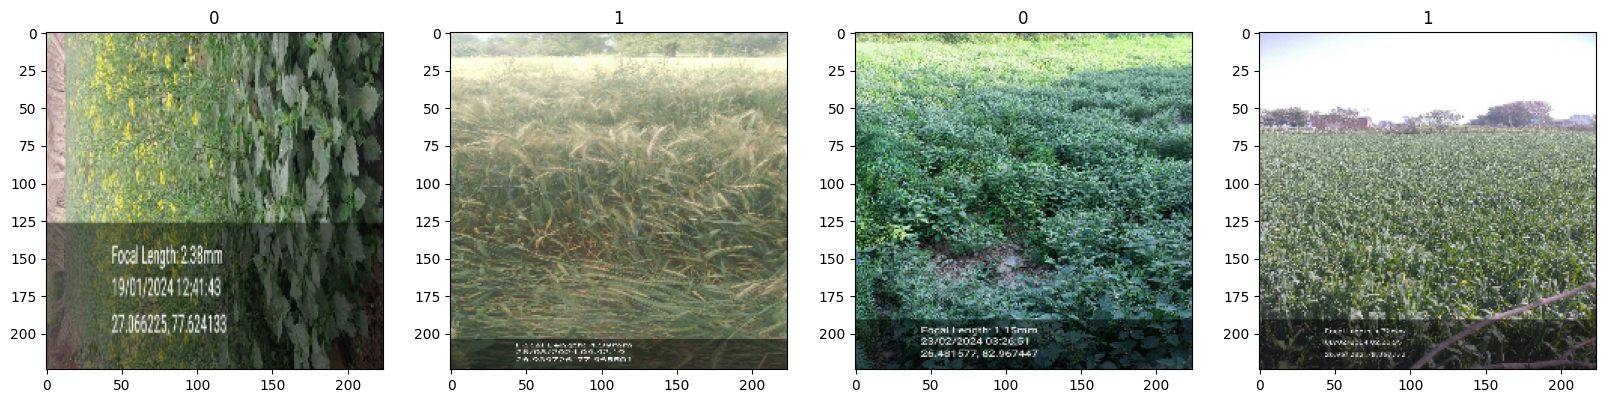

In [47]:
data_iterator = train_ds.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [48]:
def Normal(image,label):
    image = tf.cast(image/255. , tf.float32)
    return image,label

train_ds = train_ds.map(Normal)
val_ds = val_ds.map(Normal)

In [49]:
# Data Augmentation Layer
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),                      # Flip
    layers.RandomRotation(0.2),                           # Rotation
    layers.RandomZoom(0.2),                               # Zoom
    layers.RandomContrast(0.2)                            # Contrast 
])

In [50]:
train_data_iterator = train_ds.as_numpy_iterator()                # Allowing access data pipeline
batch = train_data_iterator.next()
batch[0].shape 

(32, 224, 224, 3)

#### 0 - Non-Wheat Images(Includes mustered, chana, pigeon pea, bajra etc..)
#### 1 - Wheat Images 

# 3. Model Implimentation

In [51]:
def Classify(trial):
    # Hyperparameters selection
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)                      # Learning rate
    dropout_rate = trial.suggest_float("dropout", 0.2, 0.5)              # Dropout
    dense_units = trial.suggest_int("dense_units", 64, 256, step=64)     # Dense layer neurons

    base_model = tf.keras.applications.ResNet50(
    weights="imagenet",                                                  # Using Imagenet pre-trained weights
    include_top=False,                                                   # Excluding original classification layer
    input_shape=(224, 224, 3) )                                          # Input shape for ResNet

    base_model.trainable = False                                         # Freeze ResNet-50 base layers

    inputs = keras.Input(shape=(224, 224, 3)) 

    data_augmentation = keras.Sequential([                               # Data Augumentation
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),])
    
    x = data_augmentation(inputs)                                         # Applying augmentation
    x = tf.keras.applications.resnet50.preprocess_input(x)                # Normalize
    x = base_model(x, training=False)                                     # Feature extraction
    x = layers.GlobalAveragePooling2D()(x)                                # Reduce dimensions
    x = layers.Dense(dense_units, activation="relu")(x)                   
    x = layers.Dropout(dropout_rate)(x)                                   
    outputs = layers.Dense(2, activation="softmax")(x)                    

    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"] )

    history = model.fit(
        train_ds, 
        validation_data=val_ds, 
        epochs=5,                            
        verbose=0,                                                           # Silent mode for Optuna
        callbacks=[optuna.integration.TFKerasPruningCallback(trial, "val_accuracy")] ) # Pruning
    

    return max(history.history["val_accuracy"])  # Optimize for best val accuracy

In [ ]:
# Create an Optuna study to maximize validation accuracy
study = optuna.create_study(direction="maximize")  
study.optimize(Classify, n_trials=2)                        # Trained with 10 trials with GPU                

# Print Best Hyperparameters
print("Best Hyperparameters:", study.best_params)

[I 2025-03-01 17:46:04,950] A new study created in memory with name: no-name-806d6044-26f5-47d6-a8c4-a9735d7f58a1
C:\Users\prani\AppData\Local\Temp\ipykernel_30732\2476894387.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)                      # Learning rate


Training with best hyperparameters and saving the model

In [ ]:
# Best hyperparameters
best_params = study.best_params
best_lr = best_params["lr"]
best_dropout = best_params["dropout"]
best_dense_units = best_params["dense_units"]

base_model = tf.keras.applications.ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False                                          # Building model with best hyperparameters

inputs = keras.Input(shape=(224, 224, 3))
x = tf.keras.applications.resnet50.preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(best_dense_units, activation="relu")(x)
x = layers.Dropout(best_dropout)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.compile(                                                        # Compiling with best learning rate  
    optimizer=keras.optimizers.Adam(learning_rate=best_lr),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

history = model.fit(train_ds, validation_data=val_ds, epochs=2)       # Trained with 10 epochs with GPU
model.save("resnet50_finetuned_best.keras")                           # Save the best model

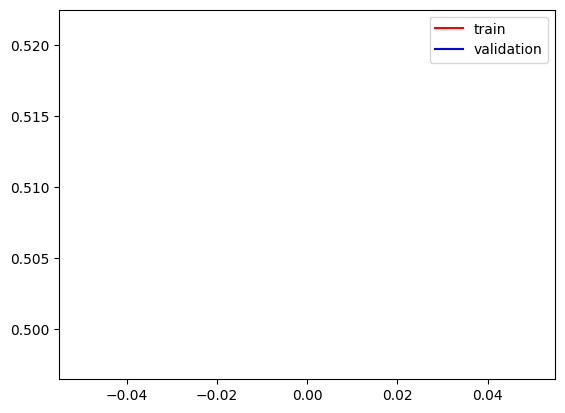

In [ ]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

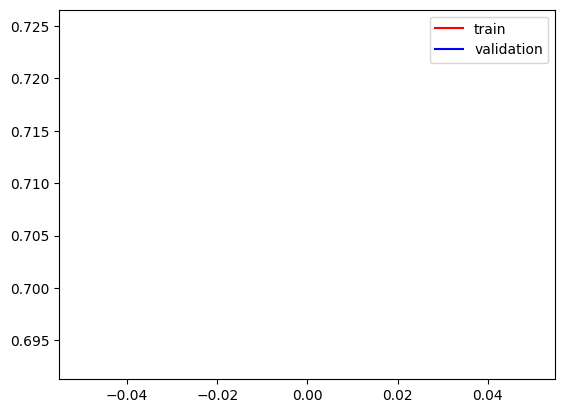

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

# 4. Finetuning Model with New data

#### Saving model after training on first dataset

In [ ]:
model.save("resnet50_finetuned.keras")                            # Saving trained model with trained weights

#### Loading New Dataset

In [ ]:
train1_dataset = "C:\\Users\\prani\\Desktop\\DCS\\Data1\\Train1"
val1_dataset = "C:\\Users\\prani\\Desktop\\DCS\\Data1\\Test1"

In [ ]:
# Fine tuning model on new dataset
from tensorflow.keras.models import load_model

model = load_model("resnet50_finetuned.keras", custom_objects=None) 

train1_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train1_dataset,
    image_size=(224, 224),  
    batch_size=32)

val1_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val1_dataset,
    image_size=(224, 224),  
    batch_size=32)

c:\Users\prani\Desktop\DCS\env\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 218 variables whereas the saved optimizer has 434 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Found 2716 files belonging to 2 classes.
Found 563 files belonging to 2 classes.


In [ ]:
# Normalizing new data
train1_ds = train1_ds.map(Normal)
val1_ds = val1_ds.map(Normal)

In [ ]:
model.trainable = True                                                      # Making all layers trainable for fine tuning

model.compile(                                                              # Compiling
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),                 # Lower Learning rate for fine tuning
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_1 = model.fit(train1_ds, epochs=1, validation_data=val1_ds)         # Trained with 10 epochs with GPU

85/85 ━━━━━━━━━━━━━━━━━━━━ 2409s 28s/step - accuracy: 0.7660 - loss: 0.4832 - val_accuracy: 0.4671 - val_loss: 0.8132


# 5. Model Evaluation

In [ ]:
# Final model evaluation
final_train_acc = history_1.history_1["accuracy"][-1]
final_val_acc = history_1.history_1["val_accuracy"][-1]
print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")

model.save("resnet50_finetuned_final.keras")                             # Saving fine-tuned model

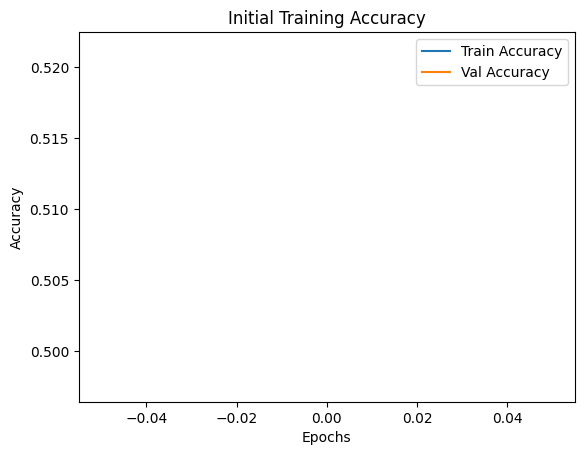

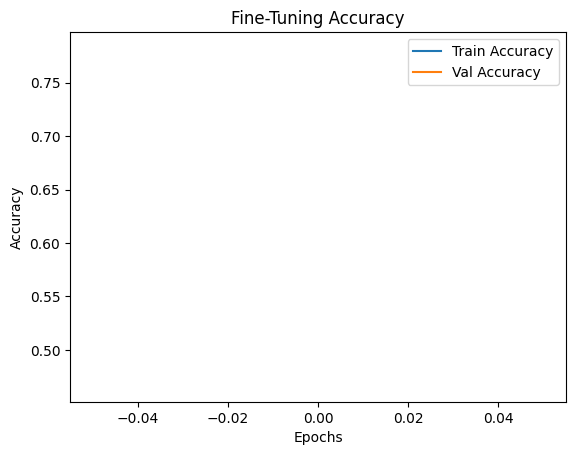

In [ ]:
# Checking of both training phases

def plot_accuracy(history, title="Training & Validation Accuracy"):
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Val Accuracy")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

plot_accuracy(history, "Initial Training Accuracy")                          # Before fine-tuning
plot_accuracy(history_1, "Fine-Tuning Accuracy")                             # After fine-tuning

In [ ]:
model.save("resnet50_fully_finetuned.keras")               # Saving Final Model